1. Inicialização de bibliotecas

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from dataclasses import dataclass

2. Métodos geradores de funções

In [33]:

def gen_square_wave (seconds, sample_rate, frequency):
    time        = np.linspace(0, seconds, sample_rate * seconds)
    amplitude   = signal.square(2 * np.pi * frequency * time)
    return time, amplitude

def wave_plot(time, amplitude, frequency):
    plt.plot(time, amplitude)
    plt.axis((0, 5 / frequency, -1.1, 1.1))
    plt.xlabel('tempo (segundos)')
    plt.ylabel('amplitude (u.a.)')

class SquareWave:
    def __init__(self, seconds, sample_rate, frequency) -> None:
        self.time, self.amplitude = gen_square_wave(seconds, sample_rate, frequency)
        self.seconds = seconds
        self.sample_rate = sample_rate
        self.frequency = frequency
    
    def plot (self):
        wave_plot(self.time, self.amplitude, self.frequency)




3. Geração e plot de onda quadrada inicial

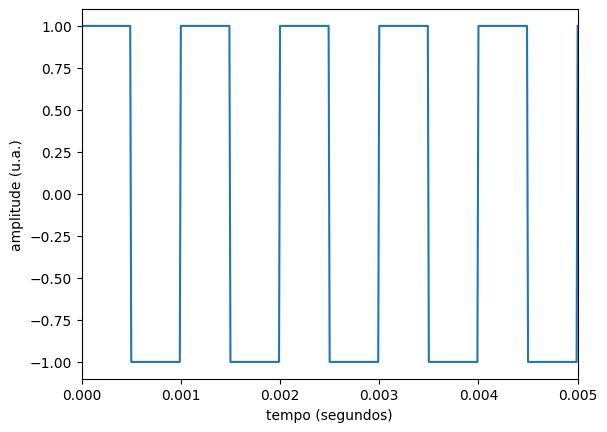

In [35]:

square_wave = SquareWave(50, 96000, 1000)
square_wave.plot()
